In [1]:
import sys
sys.path.append('../../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from mnist_reader import load_mnist_df,show_mnist_image

seed = 128
rng = np.random.RandomState(seed)

### prepping the input data

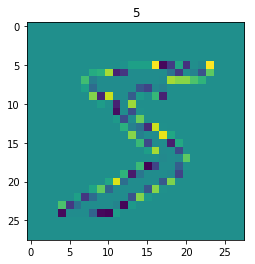

In [2]:
train_df = load_mnist_df('../../data/')
test_df = load_mnist_df('../../data/', test = True)
show_mnist_image(train_df,index=0)

In [4]:
X_train = np.array(train_df.drop('label', axis=1).astype('int8'))
X_train = X_train.astype('float32')/255
y_train = np.array(train_df.label)

X_test = np.array(test_df.drop('label', axis=1).astype('int8'))
X_test = X_test.astype('float32')/255
y_test = np.array(test_df.label)

In [5]:
split_size = int(X_train.shape[0]*0.7)

X_train, X_val = X_train[:split_size], X_train[split_size:]
y_train, y_val = y_train[:split_size], y_train[split_size:]

### setting up the model

In [12]:
# number of neurons in each layer
input_num_units = 28*28
hidden_num_units = 500
output_num_units = 10

# set remaining variables
epochs = 30
batch_size = 128
learning_rate = 0.001

model = torch.nn.Sequential(torch.nn.Linear(input_num_units, hidden_num_units),
                            torch.nn.ReLU(),
                            torch.nn.Linear(hidden_num_units, output_num_units))

loss_fn = torch.nn.CrossEntropyLoss()

# define optimization algorithm
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
## helper functions
# preprocess a batch of dataset
def preproc(unclean_batch_x):
  """Convert values to range 0-1"""
  temp_batch = unclean_batch_x / unclean_batch_x.max()
 
  return temp_batch

# create a batch
def batch_creator(X_train, y_train, batch_size):
  dataset_length = X_train.shape[0]
  
  batch_mask = rng.choice(dataset_length, batch_size)
  
  batch_x = X_train[batch_mask]
  batch_x = preproc(batch_x)
  
  batch_y = y_train[batch_mask]
  
  return batch_x, batch_y

### Running the model

In [14]:
# train network
total_batch = int(X_train.shape[0]/batch_size)

for epoch in range(epochs):
  avg_cost = 0
  for i in range(total_batch):
    # create batches
    batch_x, batch_y = batch_creator(X_train,y_train,batch_size)

    # pass that batch for training
    x, y = Variable(torch.from_numpy(batch_x)), Variable(torch.from_numpy(batch_y), requires_grad=False)
    pred = model(x)

    # get loss
    loss = loss_fn(pred, y)

    # perform backpropagation
    loss.backward()
    optimizer.step()
    avg_cost += loss.data.item()/total_batch

  print(epoch, avg_cost)

0 3.264077765549101
1 4.3892939425096245
2 4.642940652079701
3 7.192736000549504
4 10.168386869314242
5 11.734956329915578
6 10.783993816957244
7 11.513508369282984
8 11.954945296049113
9 10.883191838497064
10 11.547617548849525
11 12.87051050692069
12 12.959263377073336
13 13.698114020068468
14 13.971728878777196
15 14.54022736447613
16 13.812530781437694
17 12.501533528653587
18 12.393848765187146
19 12.487312364142111
20 12.731521413820547
21 11.667189348761635
22 9.784347445499597
23 10.132019277752896
24 9.754972421541451
25 9.28615596672383
26 9.10031210467583
27 8.717291559751441
28 8.493330669112318
29 7.919751144582175


In [15]:
# testing set accuracy
x, y = Variable(torch.from_numpy(preproc(X_train))), Variable(torch.from_numpy(y_train), requires_grad=False)
pred = model(x)

final_pred = np.argmax(pred.data.numpy(), axis=1)

accuracy_score(y_train, final_pred)

0.9372380952380952

In [57]:
# get validation accuracy
x, y = Variable(torch.from_numpy(preproc(X_val))), Variable(torch.from_numpy(y_val), requires_grad=False)
pred = model(x)
final_pred = np.argmax(pred.data.numpy(), axis=1)

accuracy_score(y_val, final_pred)

0.5713333333333334

### viewing results

neural network predicts  2 this is  True


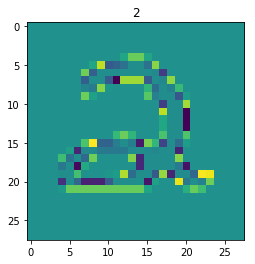

In [59]:
"""
viewing specific test cases
"""
test_index = np.random.randint(0,len(X_test))
x = Variable(torch.from_numpy(preproc(X_test[test_index])))
pred = model(x)
final_pred = np.argmax(pred.data.numpy())

print('neural network predicts ', final_pred,'this is ', final_pred == y_test[test_index])
show_mnist_image(test_df, index = test_index)